# 선형회귀 예시 (2) - 의료비에 영향을 미치는 요소
## 1. 작업 준비
### 1) 패키지 및 데이터 가져오기
- 미국 환자의 의료비가 들어 있는 데이터셋으로 `1,338개의 관측치`가 있다.

| 변수 | 의미 | 기타 |
|---|---|---|
| age | 수익자의 연령 | 수치형 |
| sex | 계약자의 성별 | 범주형 데이터(female/male) |
| bmi | 비만도. 몸무게를 키의 제곱으로 나눈 값. | 수치형<br/>정상범위: 18.5~24.9 |
| children | 의료보험이 적용되는 자녀 수 | 수치형 데이터 |
| smoker | 흡연 여부 | 범주형 데이터(yes/no) |
| region | 거주지역 | 범주형<br/>(북동: northeast, 남동: southeast / 남서: southwest / 북서: northwest) |
| charges | 의료비 | 수치형 데이터 |

In [1]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, melt, merge, get_dummies
from pca import pca
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats

In [2]:
origin = read_excel('https://data.hossam.kr/E04/insurance.xlsx')
origin

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## 2. 데이터 전처리
### 1) 데이터프레임 복사 후 결측치와 데이터타입 확인

In [4]:
edf = origin.copy()
edf.isna().sum()    # 결측치 개수 확인
edf.dtypes          # 데이터 타입 확인


age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

### 2) 범주형 타입 변환
- 범주형 필드 이름

In [4]:
cnames = ['sex', 'smoker', 'region']
cnames

['sex', 'smoker', 'region']

- 범주형 컬럼 타입 변환

In [5]:
edf2 = helper.setCategory(edf, fields=cnames, labelling=False)
edf2.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

## 3. 탐색적 데이터 분석
### 1) 수치형 변수
#### 1. 기초 통계량 확인
- 수치형 데이터 타입은 전체적인 통계값을 파악하는 것이 좋다

In [7]:
desc = edf2.describe()
desc

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


> 중앙값(50%)과 평균(mean)이 차이가 많이 난다면 데이터가 한 쪽으로 쏠려있다는 뜻이다
>
> 예) chargers (50% = 9382.033000) vs. (mean = 13270.422265)
>
> 의료비지출 변수의 통계값을 살펴보면 중앙값이 `$9,382`이고, 평균이 `$13,270`인 것을 알 수 있다. 여기서 해당 변수의 평균값이 중앙값보다 크기 때문에 의료비 분포는 오른쪽으로 꼬리가 긴 분포를 지닐 것이다.

#### 2. 전체 상자 그림 확인

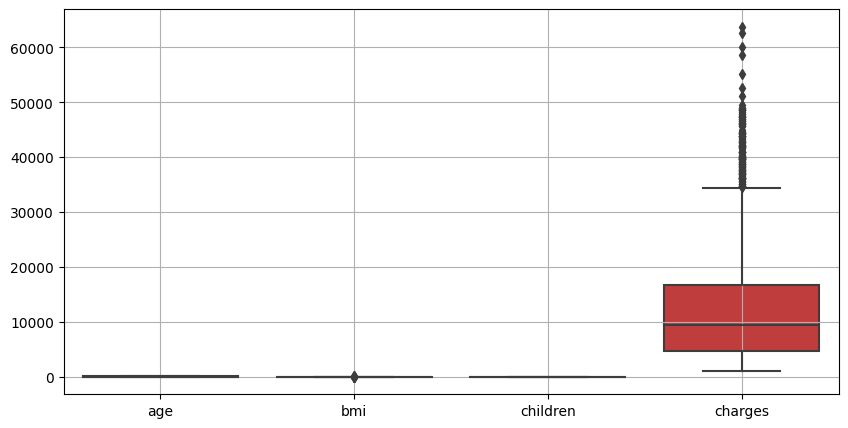

In [9]:
plt.figure(figsize = (10, 5))
sb.boxplot(data=edf)
plt.grid()
plt.show()
plt.close()

#### 3. 개별 상자그림 확인

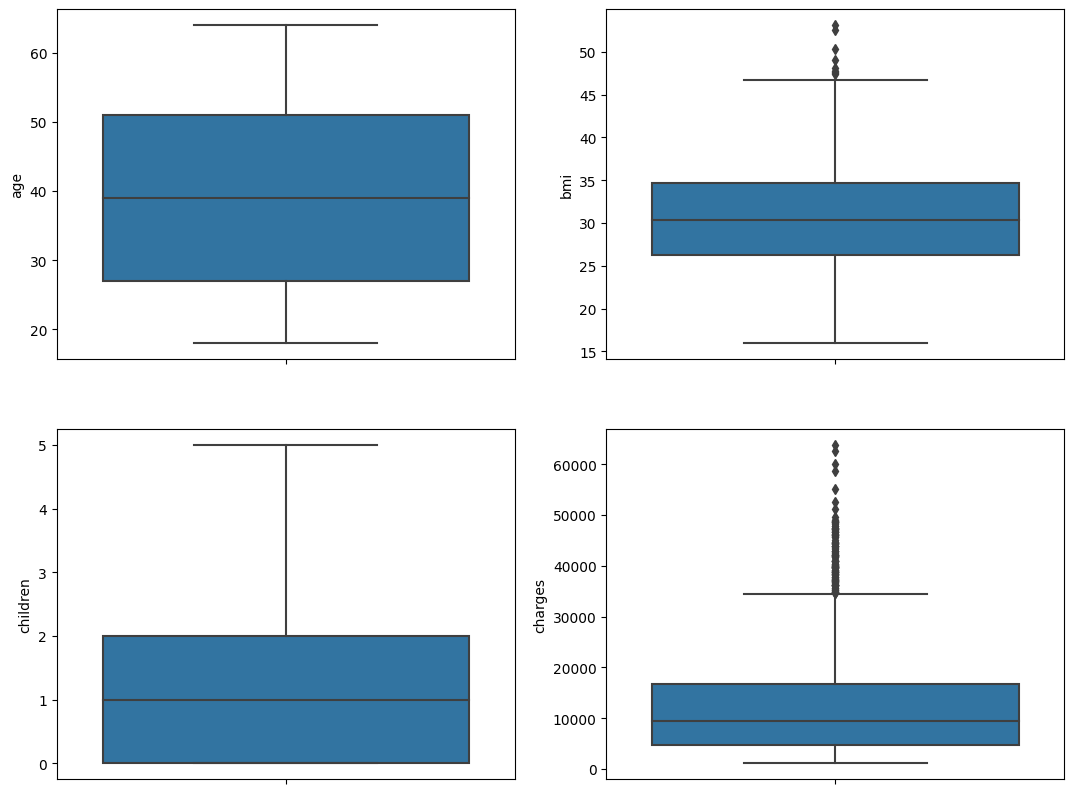

In [16]:
fig, ax = plt.subplots(2, 2, figsize = (13, 10))
rows = len(ax)
cols = len(ax[0])
for i in range(0, rows):
    for j in range(0, cols):
        idx = i * cols + j
        fieldName = desc.columns[idx]
        field = edf2[fieldName]
        sb.boxplot(edf, y=field, ax=ax[i][j])
        if idx+1 == len(desc.columns):
            break
plt.show()
plt.close()

- 이상치는 무조건 정제하는 것 아님 (예 - 비만치의 이상치들은 과체중인 사람들임)
- -> 분석가가 책임지고 이상치들이 어떤 데이터인지(이상치여서 정제할 데이터인지, 아니면 이상치가 아닌 가치 있는 데이터여서 냅둘 데이터인지) 결정해야 됨
#### 4. 히스토그램 확인

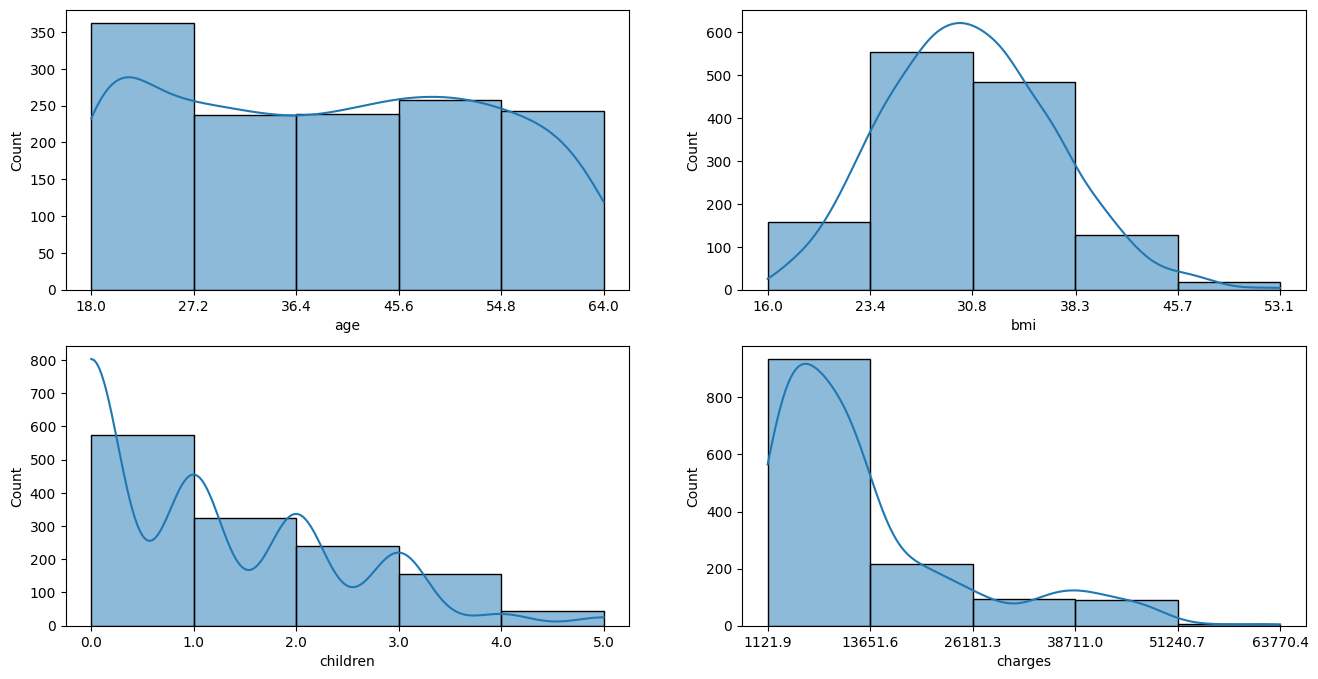

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
rows = len(ax)
cols = len(ax[0])
for i in range(rows):
    for j in range(cols):
        idx = i * cols + j
        fieldName = desc.columns[idx]
        field = edf[fieldName]
        hist, bins = np.histogram(field, bins = 5)
        bins2 = np.round(bins, 1)
        sb.histplot(data = edf2, x=fieldName, bins=5,
                    kde=True, ax=ax[i][j])
        ax[i][j].set_xticks(bins2)
        ax[i][j].set_xticklabels(bins2)
        if idx+1 == len(desc.columns):
            break
plt.show()
plt.close()

> 대부분의 사람들은 연간 `$15,000 이하의 의료비 지출`에 분포되어 있음을 알 수 있다.
>
> 마찬가지로 `bmi지수`를 살펴보면 `과체중이상의 데이터가 절반 이상을 차지`하는 것을 알 수 있다 (정상범위: 18.5~24.9)

#### 5. 각 변수 간의 관계 파악
- 수치형 변수드의 이름

In [20]:
nnames = list(desc.columns)
nnames
ndf = edf.filter(nnames)
ndf

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


- 산점도 행렬

<Figure size 2000x2000 with 0 Axes>

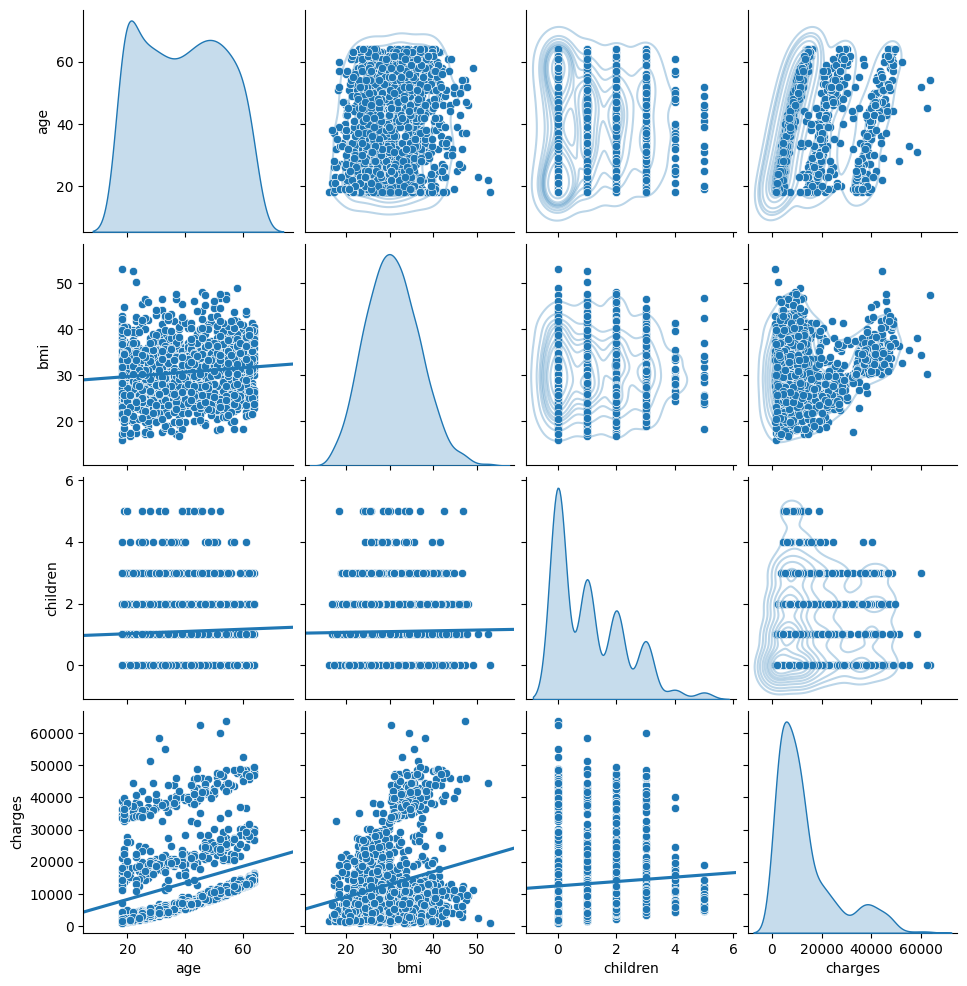

In [21]:
plt.figure(figsize=(20, 20))
g = sb.pairplot(ndf, diag_kind='kde')
g.map_upper(sb.kdeplot, alpha=0.3)
g.map_lower(sb.regplot, scatter=False, truncate=False, ci=False)
plt.show()
plt.close()

> 이 그림에서 어떤 패턴이 눈에 띄는지 살펴보면 특정한 관계를 찾기는 어려워보임
> 
> 여기 연령과 의료비지출의 산포도를 살펴보니, 상대적으로 직선 형태로 분포되어 있음을 볼 수 있다.
>
> 또, bmi지수와 의료비지출은 크게 두 개의 군집(cluster)로 나뉘어져 있는 것으로 보인다.
>
> 전체적으로 강한 상관관계를 보이지는 않지만 age-bmi, age-charges, children-charges가 약한의 상관관계를 보인다.
>
>나이가 들수록 몸무게가 증가하고, bmi 수치가 높거나 부양가족 수가 많아질 수록 의료비가 증가하는 것은 어느정도 합리적인 결과라 할 수 있겠다.

- 상관행렬
    - 대각선은 변수 자신이기에 항상 '1'이 표기됨
    - 상관계수는 1에 가까울수록 두 변수가 같은 방향으로 양의 상관관계가 높다고 판단할 수 있고, -1에 가까울수록 반대 방향으로 음의 상관관계가 높다는 것을 나타냄

In [22]:
corr = ndf.corr(method='pearson')
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


> 연령, bmi지수, 부양가족 수, 의료비지출은 약하지만 `모두 양(+)의 상관관계`를 보이고 있다.
> 
> 예) 연령과 bmi지수는 나이가 들어갈 수록 몸무게가 증가되면서 bmi 지수가 높아지는 경향을 설명할 수 있고, 부양가족 수가 증가하면 의료비 지출이 많아진다고 보는 것도 합리적인 판단이 될 수 있다.

### 6) PCA 분석
- 회귀 분석에 필요한 요인들을 선정하기 위해 주성분 분석을 수행한다
#### 데이터 표준화
- 범주형은 PCA를 수행할 수 없기에 수치형 변수만 추출해 둔 `ndf`를 사용
- 종속 변수인 의료비 필드는 제외하고 진행

In [31]:
x_train_std_df, y_train_std_df = helper.scalling(ndf[nnames], 'charges')
x_train_std_df

,age,bmi,children
0,-1.438764,-0.453320,-0.908614
1,-1.509965,0.509621,-0.078767
2,-0.797954,0.383307,1.580926
3,-0.441948,-1.305531,-0.908614
4,-0.513149,-0.292556,-0.908614
...,...,...,...
1333,0.768473,0.050297,1.580926
1334,-1.509965,0.206139,-0.908614
1335,-1.509965,1.014878,-0.908614
1336,-1.296362,-0.797813,-0.908614


#### PCA

In [32]:
model = pca()
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(x_train_std_df)
topfeat = fit['topfeat']

best = topfeat.query("type=='best'")
best_names = list(set(list(best['feature'])))
print(best_names)

topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [3] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [3] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
['children', 'age']


,PC,feature,loading,type
0,PC1,age,0.692028,best
1,PC2,children,0.931148,best
2,PC3,age,-0.717326,best
3,PC3,bmi,0.669385,weak



### 2) 범주형 변수
#### 1. 종류별로 데이터 수량 확인

In [33]:
for name in cnames:
    print(edf2[name].value_counts())

sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
northwest    325
southwest    325
northeast    324
Name: count, dtype: int64


#### 2. 범주형 데이터의 데이터분포 시각화

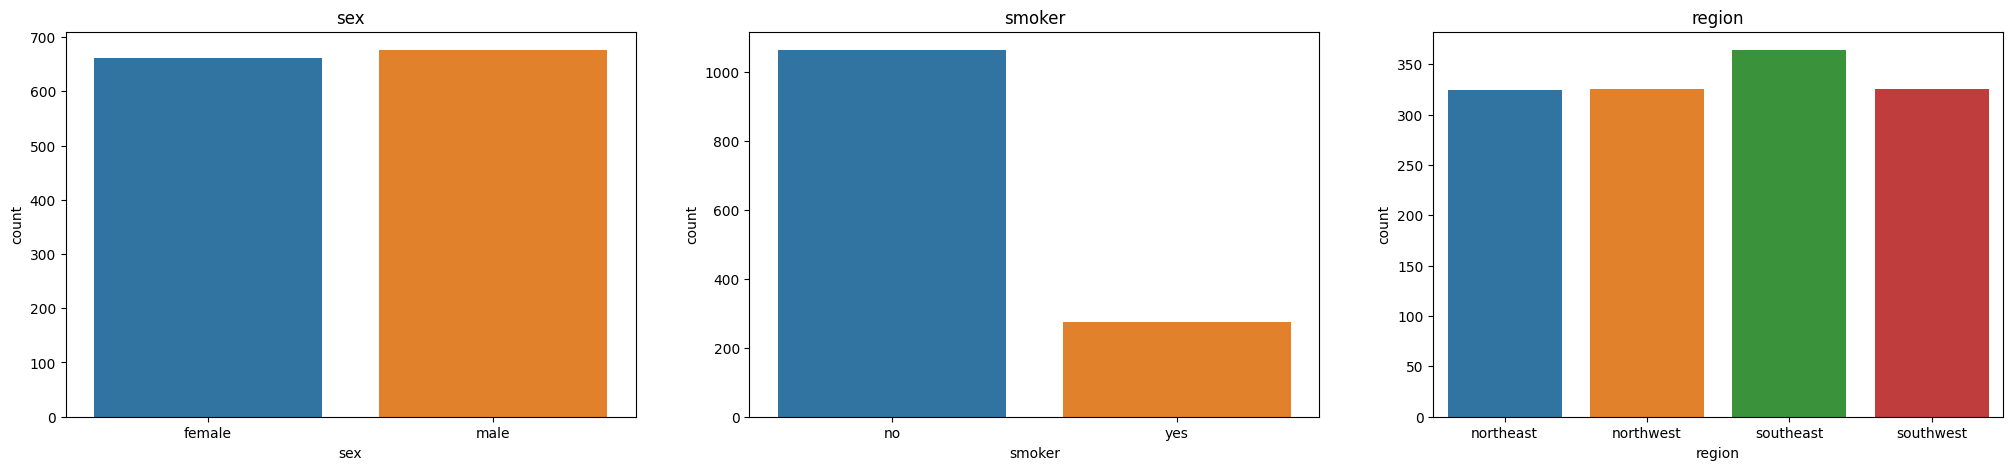

In [34]:
fig, ax = plt.subplots(1, len(cnames), figsize=(25, 5))

for i, v in enumerate(cnames):
    vc = DataFrame(edf2[v].value_counts(), columns=['count'])
    #print(vc)
    sb.barplot(data=vc, x=vc.index, y='count', ax=ax[i])
    ax[i].set_title(v)
    
plt.show()
plt.close()

> 흡연 여부의 경우 비흡연자가 많이 분포되어 있다.
> 
> 그 밖에 성별과 지역의 경우 비슷하게 분포되어 있기 때문에 `분산분석을 통해 통제요인으로 넣는 것`을 고려해 볼 수 있겠다.

#### 3. 범주형 변수에 따라 평균이 차이가 나는지 확인
- 라벨링을 적용한 데이터프레임 생성

In [35]:
ldf = helper.setCategory(edf, fields=cnames, labelling=True)
print(ldf.dtypes)

{'female': 0, 'male': 1}
{'no': 0, 'yes': 1}
{'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}
age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object


- 분산분석

In [36]:
lm = ols('charges ~ C(sex)+C(smoker)+C(region)+C(sex):C(smoker)+C(smoker):C(region)+C(region):C(sex)+C(sex):C(smoker):C(region)', data=ldf).fit()
lmdf = anova_lm(lm)
lmdf['결과'] = lmdf['PR(>F)'] < 0.05
print(lmdf)

                                df        sum_sq       mean_sq            F  \
C(sex)                         1.0  6.435902e+08  6.435902e+08    11.730026   
C(smoker)                      1.0  1.208777e+11  1.208777e+11  2203.108485   
C(region)                      3.0  1.078004e+08  3.593345e+07     0.654920   
C(sex):C(smoker)               1.0  4.904163e+08  4.904163e+08     8.938290   
C(smoker):C(region)            3.0  1.344084e+09  4.480281e+08     8.165726   
C(region):C(sex)               3.0  1.382281e+06  4.607604e+05     0.008398   
C(sex):C(smoker):C(region)     3.0  7.517058e+07  2.505686e+07     0.456684   
Residual                    1322.0  7.253404e+10  5.486690e+07          NaN   

                                   PR(>F)     결과  
C(sex)                       6.338371e-04   True  
C(smoker)                   7.872124e-284   True  
C(region)                    5.799028e-01  False  
C(sex):C(smoker)             2.844155e-03   True  
C(smoker):C(region)          2.18

> 성별과 흡연 여부에 대한 p값이 모두 0.05 미만이므로 두 요인은 의료비 지출에 통계적으로 유의미한 영향을 미친다고 볼 수 있다.
>
> `성별과 흡연량`, `흡연량과 지역` 간에는 `교효작용 효과가 있음`이 발견되었다.

- 교호작용을 보이는 변수간의 비교

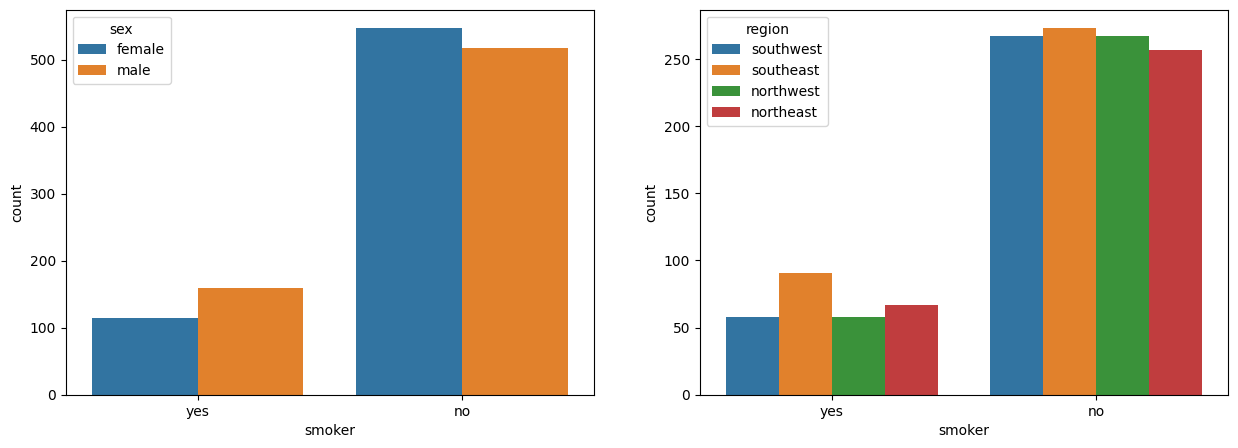

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sb.countplot(data=edf, x='smoker', hue='sex', ax=ax1)    
sb.countplot(data=edf, x='smoker', hue='region', ax=ax2)

plt.show()
plt.close()

## 4. 최종적으로 선정된 요인

| 구분 | 변수 | 의미 | 기타 |
|---|---|---|---|
| 종속변수 | charges | 의료비 | 수치형 데이터 |
| 독립변수 | age | 수익자의 연령 | 수치형 |
| 독립변수 | bmi(?) | 비만도. 몸무게를 키의 제곱으로 나눈 값. | 수치형<br/>정상범위: 18.5~24.9 |
| 독립변수 | children | 의료보험이 적용되는 자녀 수 | 수치형 데이터 |
| `통제요인 `| sex | 계약자의 성별 | 범주형 데이터(female/male) |
| `통제요인` | smoker | 흡연 여부 | 범주형 데이터(yes/no) |

- 
>
> 거주지역은 상관이 없다고 판단하여 뺌
>

## 5. 다중선형 회귀분석
- case 1: 모든 변수 적용
- case 2: bmi를 제거하고 적용
- case 3: 모든 변수 적용 + 표준화 적용
- case 4: bmi를 제거하고 적용 + 표준화 적용

### 1) 분석 케이스에 따른 분석용 데이터 생성

In [38]:
def get_df(case_number, is_scale=False):
    # bmi를 제거하지 않은 경우
    if case_number == 1:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'bmi', 'children', 'sex', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['sex', 'smoker']
    # bmi를 제거한 경우
    elif case_number == 2:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'children', 'sex', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['sex', 'smoker']
    # 성별을 제거한 경우
    elif case_number == 3:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'bmi', 'children', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['smoker']
    # 성별과 bmi을 제거한 경우
    elif case_number == 4:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'children', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['smoker']
        
    # 표준화를 적용하지 않은 경우
    if not is_scale:
        tmp = origin.filter(fnames1)
    # 표준화를 적용한 경우
    else:
        # 미리 적용해 둔 표준화 결과를 병합
        left = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True).filter(fnames1)
        # 원본에서 명목형만 다시 추출
        right = origin.filter(fnames2)
        # 결합
        tmp = merge(left, right, left_index=True, right_index=True)
        None
        
    tmp2 = get_dummies(tmp, columns=fnames2, drop_first=True, dtype='int')
    return tmp2

In [40]:
target_df = get_df(1, True)     # 밑에 하나씩 해 보고 분석결과 봐야 함
# target_df = get_df(1, False)
# target_df = get_df(2, True)
# target_df = get_df(2, False)
# target_df = get_df(3, True)
# target_df = get_df(3, False)
# target_df = get_df(4, True)
# target_df = get_df(4, False)
helper.prettyPrint(target_df.head())

# 독립변수 이름만 추출
xnames = list(target_df.columns)
xnames.remove('charges')
#xnames

ols_result = helper.myOls(target_df, y='charges', x=xnames)

helper.prettyPrint(ols_result.table)
print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

+----+-----------+-----------+-----------+------------+------------+--------------+
|    |   charges |       age |       bmi |   children |   sex_male |   smoker_yes |
|----+-----------+-----------+-----------+------------+------------+--------------|
|  0 |  0.298584 |  -1.43876 |  -0.45332 |  -0.908614 |          0 |            1 |
|  1 | -0.953689 |  -1.50997 |  0.509621 | -0.0787672 |          1 |            0 |
|  2 | -0.728675 | -0.797954 |  0.383307 |    1.58093 |          1 |            0 |
|  3 |  0.719843 | -0.441948 |  -1.30553 |  -0.908614 |          1 |            0 |
|  4 | -0.776802 | -0.513149 | -0.292556 |  -0.908614 |          1 |            0 |
+----+-----------+-----------+-----------+------------+------------+--------------+
+---------------------------+---------+------------+-----+---------+------------+---------+
|                           |       B |   표준오차 |   β | t       |   유의확률 |     VIF |
|---------------------------+---------+------------+-----+---------+

- VIF = 다중공선성 (10에 가까울수록 다중공선성이 높은 것임 -> charges, age가 조금 다중공선성이 높아 보임) (수치가 작을수록 좋음)

> 결과: 비만도(bmi)를 안 빼야됨
